### Constants

In [26]:
import os

# directories
INTERACTIVE_READER = True
TOTAL_IMAGE_SNAPSHOTS = 10
LOGS_DIRECTORY = os.path.join("__logs__")
DATA_DIRECTORY = os.path.join("__data__")
TEMP_DIRECTORY = os.path.join("__temp__")
MODELS_DIRECTORY = os.path.join("public/models")
FACES_DIRECTORY = os.path.join(DATA_DIRECTORY, "faces")

# models
DNN_MODEL_PATH = os.path.join(MODELS_DIRECTORY, "opencv_face_detector_uint8.pb")
DNN_MODEL_CONFIG_PATH = os.path.join(MODELS_DIRECTORY, "opencv_face_detector.pbtxt")

### Helpers

In [3]:
import cv2
import sys

# get the face detector ( using opencv's dnn model)
def get_detector():
    net = cv2.dnn.readNet(DNN_MODEL_PATH, DNN_MODEL_CONFIG_PATH)
    net.setPreferableBackend(cv2.dnn.DNN_BACKEND_OPENCV)
    net.setPreferableTarget(cv2.dnn.DNN_TARGET_CPU)

    detector = cv2.dnn_DetectionModel(net)
    detector.setInputParams(size=(200, 200), scale=1, mean=(104, 117, 123), swapRB=True)
    
    return detector


# utility function to show progress size
def reporthook(count, block_size, total_size):
    percent = min((count * block_size * 100 / total_size), 100)
    sys.stdout.write("\r%.2f%%" % percent)
    sys.stdout.flush()


2023-03-12 01:19:15.121439: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Setup directories

In [ ]:
import os
from urllib import request

for directory in [TEMP_DIRECTORY, LOGS_DIRECTORY, DATA_DIRECTORY, MODELS_DIRECTORY, FACES_DIRECTORY]:
    if not os.path.isdir(directory):
        print(f"creating `{directory}` directory.")
        os.mkdir(directory)

for file in [DNN_MODEL_PATH, DNN_MODEL_CONFIG_PATH]:
    if not os.path.isfile(file):
        print(f"downloading `{file}` from github...")
        request.urlretrieve(
            f"https://raw.githubusercontent.com/sharmapukar217/minor-project-resources/main/{file}",
            file,
            reporthook,
        )
        print(f"\nfile saved to `{file}`.")

creating `__data__/faces` directory.


### Setup faces ( for random subjects/faces )

In [ ]:
import os
import cv2
import shutil
import numpy as np
from tqdm import tqdm
from zipfile import ZipFile

detector = get_detector()
if len(os.listdir(FACES_DIRECTORY)) == 0:
    file = "archive.zip"
    print("creating face datas...")
    if not os.path.isfile(file):
        print(f"downloading `{file}` file from github...")
        request.urlretrieve(f"https://raw.githubusercontent.com/sharmapukar217/minor-project-resources/main/{file}",file, reporthook)
    print("extracting and processing faces...")
    with ZipFile(file, "r") as archive:
        namelist = list(filter(lambda x: (x.startswith("subject")), archive.namelist()))
        pbar = tqdm(total=len(namelist))
        for name in namelist:
            if name.startswith("subject"):
                classId = name.split(".")[0]
                archive.extract(name, f"{TEMP_DIRECTORY}/faces")
                cap = cv2.VideoCapture(f"{TEMP_DIRECTORY}/faces/{name}")
                ret, image = cap.read()
                if ret:
                    faces = detector.detect(image, 0.5)[2]
                    if len(faces) != 0:
                        x, y, w, h = faces[0]
                        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
                        dir = f"{FACES_DIRECTORY}/$_{classId}"
                        if not os.path.isdir(dir):
                            os.mkdir(dir)        
                        cv2.imwrite(f"{dir}/{name}.jpg", gray)
                        pbar.update(1)
        # cleanup
        pbar.close()
        print("cleaning up...")
        
        archive.close()
        cv2.destroyAllWindows()
        shutil.rmtree(f"{TEMP_DIRECTORY}/faces")

creating face datas...
extracting and processing faces...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 165/165 [00:25<00:00,  6.53it/s]

cleaning up...


### Setup face reader ( for real faces )

In [116]:
import os
import cv2
import sys
import time
from cuid import cuid

detector = get_detector()

# read person's name for label
name = ""
while name.strip() == "":
    name = input("Enter the name of the person:")
label = "$_" + name.strip().lower().replace(" ", "_")

dir = os.path.join(DATA_DIRECTORY, "faces", label)
if not os.path.isdir(dir):
    os.mkdir(dir)
else:
    letter = input("label/name already exists, rewrite? [y/N]")
    letter = letter.lower().strip()
    if letter != "y":
        sys.exit("closing the face reader.")

elapsed_time = 0

# start camera for face data
cap = cv2.VideoCapture(0)

(count, started) = (0, False)
while cap.isOpened():
    ret, frame = cap.read()
    
    if not ret:
        print("can't stream the video. exitting...")
        break
    
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    current_time = time.time()
    faces = detector.detect(frame.copy(), 0.4)[2]

    # only show the first detection
    # assuming only single face is present
    # while reading the person's face for training
    if len(faces) != 0:
        cv2.rectangle(frame, faces[0], (255, 255, 255), 5)

    frame = cv2.flip(frame, 1)  # flip around y axis
    fps = int((1 / (current_time - elapsed_time)))
    elapsed_time = current_time

    cv2.namedWindow("frame", cv2.WINDOW_NORMAL)
    cv2.putText(frame, f"fps: {fps}", (7, 30), cv2.FONT_HERSHEY_DUPLEX, 0.8, (100, 255, 0), 2, cv2.LINE_AA)
    cv2.imshow("frame", frame)
    
    key = cv2.waitKey(1)
    if key == ord("q"):
        print("\nexitting the face reader...")
        break
    elif key == ord("c"):
        started =  True
 
    sys.stdout.write(f"\rsnapshot: #{count+1}: (q) to exit, (c) to start capturing snapshot.")
    sys.stdout.flush()
    
    if started:
        if len(faces) != 0:
            # image = cv2.resize(gray[y:y+h, x:x+w], (100, 100), interpolation=cv2.INTER_AREA)
            image_path = f"{dir}/{cuid()}.jpg"
            cv2.imwrite(image_path, gray[y:y+h, x:x+w])
            time.sleep(0.05)
            count+=1
            if INTERACTIVE_READER: started = False
        else:
            sys.stdout.write("\rNo face found to take snapshot.")
            sys.stdout.flush()
            
    if count >= TOTAL_IMAGE_SNAPSHOTS:
        print(f"\ndone taking {count} snapshots. closing...")
        break
        
cap.release()
cv2.destroyAllWindows()

Enter the name of the person: sushil_ghimire


can't stream the video. exitting...


[ WARN:0@11838.431] global cap_v4l.cpp:1119 tryIoctl VIDEOIO(V4L2:/dev/video0): select() timeout.


### Generate dataset

In [416]:
from PIL import Image

def generate_data_set():
    id = 0
    (labels, faces, ids) = ({}, [], [])
    for directory in os.listdir(FACES_DIRECTORY):
        if directory.startswith("$_"):
            label = directory.split("$_")[1]
            for img_file in os.listdir(f"{FACES_DIRECTORY}/{directory}"):
                if img_file.endswith(".pgm"):
                    img = Image.open(f"{FACES_DIRECTORY}/{directory}/{img_file}").convert("L").resize((100, 100), Image.LANCZOS)
                    img_arr = np.array(img, "uint8")
                    id = id + 1  # keeping 0 for unknowns
                    faces.append(img_arr)
                    labels[id] = label
                    ids.append(id)
                    
    return labels, np.asarray(faces), np.asarray(ids)

### Plot the dataset

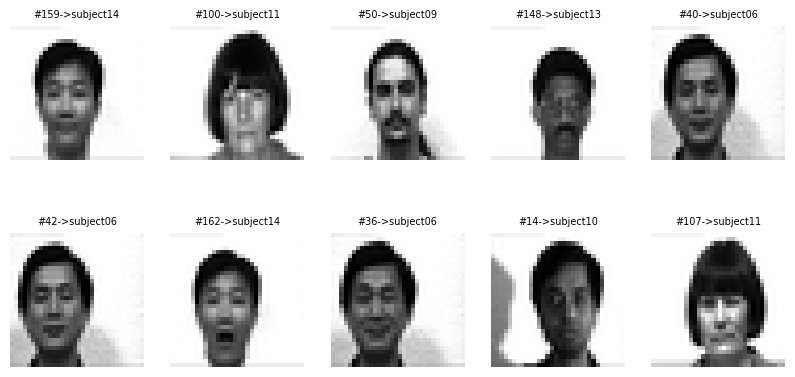

In [403]:
from sklearn.utils import shuffle

labels, faces, ids = generate_data_set()
faces, ids = shuffle(faces, ids)

def plot_random_img(n=10, rows=5 ,cols=5):
    fig=plt.figure(figsize=(rows+5, cols+8))
    for i in range(0, min(n, ids.shape[0])):
        img = faces[i]
        fig.add_subplot(rows, cols, i+1)
        plt.imshow(img,cmap='gray')
        plt.title(f"#{ids[i]}->{labels.get(ids[i])}", fontsize=7)
        plt.axis('off')
    plt.show()

plot_random_img(10)

### Train model

In [428]:
from PIL import Image
from keras.utils import to_categorical
from keras import callbacks, backend as K
from sklearn.model_selection import train_test_split

# def downsample_image(img):
#     img = Image.fromarray(img.astype('uint8'), 'L')
#     img = img.resize((32,32), Image.LANCZOS)
#     return np.array(img)

K.clear_session()
labels, faces,ids = generate_data_set()
# faces = np.array([downsample_image(ab) for ab in faces])
faces = np.array(faces)
faces = faces[:,:,:,np.newaxis]
faces = faces.astype('float32')
faces /= 255.

# one hot encoding
ids = to_categorical(ids)

x_train, x_test, y_train, y_test = train_test_split(faces,ids, test_size = 0.2, random_state = 0)
checkpoint = callbacks.ModelCheckpoint('trained_model.h5', monitor='val_acc',
                                           save_best_only=True, save_weights_only=True, verbose=1)
